In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torchvision import transforms
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [2]:
torch.__version__

'0.4.1'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print device

cuda


In [4]:
# Pretrained model
vgg19 = models.vgg19(pretrained=True).to(device).eval()

In [5]:
VG = '../dumps/tue.jpg'#'../dumps/vg.jpg'
TUE = '../dumps/vg.jpg' #'../dumps/tue.jpg'

In [6]:
# Loading image
import matplotlib.pyplot as plt
from torchvision import transforms

def process(path):
    img = plt.imread(path)
    transformer = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
        ]
    )
    return transformer(img).to(device)

def show_image(img):
    img = img.squeeze(0)
    img = img.numpy()
    img = img.swapaxes(0, 2)
    img = img.swapaxes(0, 1)
    print img.shape
    plt.imshow(img)
    plt.show()

In [7]:
tue = process(TUE)
vg = process(VG)

tue = tue.unsqueeze(0)
vg = vg.unsqueeze(0)

In [8]:
# Training
style = torch.autograd.Variable(vg).to(device) # Style from Van-Gogh image
content = torch.autograd.Variable(tue).to(device) # Content from TUE
output = torch.rand(vg.size(), requires_grad=True).to(device)

# output.size()

In [9]:
# Function to be recomputed in each step
# Register forward hook & extract internal network features
features = []

def save_features(self, inp, out):
    features.append(out)

for layer in vgg19.features:
    if isinstance(layer, torch.nn.ReLU):
        layer._forward_hooks = OrderedDict()
        layer.register_forward_hook(save_features)

In [10]:
# Precomputed content features
vgg19.features.forward(tue)
tue_features = copy.copy(features)
features = []

In [11]:
# Precomputed style features
vgg19.features.forward(vg)
vg_features = copy.copy(features)
features = []

In [12]:
(tue_features[0] - vg_features[0]).sum()

tensor(151864.4375, device='cuda:0', grad_fn=<SumBackward0>)

In [25]:
# Losses
def content_loss(radom_fm, content_fm):
    '''

    Content loss by Gatys et al.

    Parameters
    ----------
    radom_fm: torch.Tensor
        Feature map for random image
    content_fm:
        Feature map for style image

    Returns
    -------

    '''

    return 0.5 * ((radom_fm - content_fm) ** 2).sum()


def style_loss(radom_fm, style_fm):
    '''

    Style loss by Gatys et al.

    Parameters
    ----------
    radom_fm: torch.Tensor
        Feature map for random image
    style_fm:
        Feature map for style image

    Returns
    -------

    '''

    a = gram_matrix(radom_fm)
    g = gram_matrix(style_fm)
    
    #print a.shape

    N = a.shape[0]
    M = a.shape[1] #* a.shape[2]
    
    loss = 0.5 * ((g - a) ** 2).sum()
    #loss = 1./(4 * N**2 * M**2) * ((g- a)**2).sum()
    return loss

def gram_matrix(x):
    #print x.size()
    a, b, c, d = x.size()
    features = x.view(a * b, c*d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c *d)

def get_loss(random_fm_list, content_fm_list, style_fm_list, alpha=0.001):

    # print "Getting loss..."
    
    #print len(random_fm_list), len(content_fm_list), len(style_fm_list)

    style_loss_vals =[]
    content_loss_vals = []

    for rf, cf, sf in zip(random_fm_list, content_fm_list, style_fm_list):
        style_loss_vals.append(style_loss(rf, sf)*10000*2)
        content_loss_vals.append(alpha * content_loss(rf, cf))
    
    sl = sum(style_loss_vals)
    cl = sum(content_loss_vals)

    return sl + cl, sl, cl

In [26]:
# Optimizing
EPOCHS = 100

In [27]:
optimized_param = torch.nn.Parameter(output.data)
opt = torch.optim.LBFGS([optimized_param.requires_grad_()])

In [28]:
#vgg19.features.forward(optimized_param)
#output_features = copy.copy(features)
#features = []
# output_features[0].shape

In [29]:
def loss_fun():
    opt.zero_grad()
    global features
    vgg19.features.forward(optimized_param)
    output_features = copy.copy(features)
    features = []
    output_features[0].shape
    
    global s_loss, c_loss
    
    total_loss, s_loss, c_loss = get_loss(output_features, tue_features, vg_features)
    total_loss.backward(retain_graph=True)
    return total_loss

In [30]:
features

[]

In [31]:
for i in range(EPOCHS):
    loss_val = opt.step(loss_fun)
    #show_image(optimized_param.data)
    print "Iter {}: {} | style loss: {} | content loss: {}".format(i, loss_val, s_loss, c_loss)

Iter 0: 50511.21875 | style loss: 18421.015625 | content loss: 30616.1484375
Iter 1: 49007.3828125 | style loss: 17306.5039062 | content loss: 31308.2011719
Iter 2: 48600.34375 | style loss: 16806.9394531 | content loss: 31573.8261719
Iter 3: 48372.0507812 | style loss: 16509.8144531 | content loss: 31716.5546875
Iter 4: 48220.3203125 | style loss: 16297.6445312 | content loss: 31818.9882812
Iter 5: 48111.5976562 | style loss: 16166.1123047 | content loss: 31858.1679688
Iter 6: 48019.8984375 | style loss: 16027.4169922 | content loss: 31919.1601562
Iter 7: 47942.96875 | style loss: 15928.4746094 | content loss: 31952.3730469
Iter 8: 47877.8515625 | style loss: 15834.9042969 | content loss: 31986.328125
Iter 9: 47818.2851562 | style loss: 15760.9150391 | content loss: 32005.9863281
Iter 10: 47764.4140625 | style loss: 15694.2675781 | content loss: 32023.8730469
Iter 11: 47715.8359375 | style loss: 15638.7910156 | content loss: 32035.4609375
Iter 12: 47672.2304688 | style loss: 15589.824

KeyboardInterrupt: 

In [282]:
#show_image(output.data)

In [32]:
def show_image_revert(img):
    mean = [0.485, 0.456, 0.406]
    std =[0.229, 0.224, 0.225]
    img = img.squeeze(0)
    img = img.cpu().numpy()
    img = img.swapaxes(0, 2)
    img = img.swapaxes(0, 1)
    img = (img * std) + mean
    print img.shape
    plt.imshow(img)
    plt.show()

(256, 256, 3)


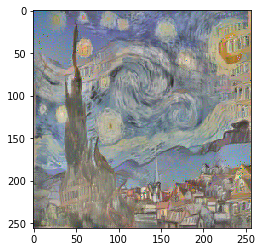

In [33]:
show_image_revert(output.data)

(256, 256, 3)


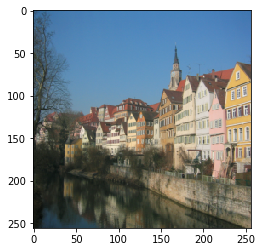

In [102]:
show_image_revert(tue)